In [1]:
import re
import glob
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
from IPython.display import HTML, Audio, display
import random
import os
import sys
import itertools
import librosa
import time

os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import torch
from mel2wav import MelVocoder


In [2]:
import yaml

In [3]:
yaml.__version__

'5.3.1'

In [4]:
! ls logs/handpicked_ssb_debug

args.yml				       original_1.wav  original_5.wav
events.out.tfevents.1593326892.HPC2-1.17759.0  original_2.wav  original_6.wav
events.out.tfevents.1593326985.HPC2-1.19481.0  original_3.wav  original_7.wav
original_0.wav				       original_4.wav


In [5]:
with open('logs/handpicked_ssb_debug/args.yml') as f : 
    print(yaml.load(f, Loader=yaml.UnsafeLoader))

Namespace(batch_size=16, cond_disc=False, downsamp_factor=4, epochs=3000, lambda_feat=10, load_path=None, log_interval=100, n_layers_D=4, n_mel_channels=80, n_residual_layers=3, n_test_samples=8, ndf=16, ngf=32, num_D=3, samplerate=16000, save_interval=1000, save_path='../logs/handpicked_ssb_debug', seq_len=6400)


In [6]:
# melgan = MelVocoder('logs/ssb_tacotron_130/',use_best = False, github=False)
melgan = MelVocoder('logs/handpicked_ssb_odd/',use_best = False, github=False)

In [7]:
import glob

samplerate = 16000

MBASE    = '/home/shiyao/netdata/tacotron_base/logs-aishell_ssb/manual_output/demo/mels'
SSBASE   = '/home/shiyao/netdata/tacotron_base/aishell_ssb-train/'
GTABASE  = os.path.join(SSBASE, 'gta')
TRUEBASE = os.path.join(SSBASE, 'mels')
NATBASE  = os.path.join(SSBASE, 'natural')
AUDBASE  = os.path.join(SSBASE, 'audio')
HFBASE   = '/NASdata/AudioData/AISHELL-ASR-SSB/SPEECHDATA/'

# available out-of-domain samples : 
fs = glob.glob(os.path.join(MBASE, '*.npy'))
print('available out-of-domain sample names : ')
for f in fs : 
    print(f'\t* {os.path.basename(f)}')
    
# available in-domain sample groups : 
width = 8
fs = glob.glob(os.path.join(TRUEBASE, '*'))
print('available in-domain sample groups(speakers) : ')
c_vertical = 1
for f in fs : 
    if c_vertical % width == 0 : 
        end = '\n'
    else : 
        end = ''
        
    start = '\t' if (c_vertical-1) % width == 0 else ''
    print(f'{start}* {os.path.basename(f)}  ', end=end)
    c_vertical += 1
    
def audio_from_mel(melpath) : 
    mel = np.load(melpath)
    wav = infer_waveform(mel.T)
    return wav

def get_synth_mel(spkid) : 
    return os.path.join(MBASE, f'spk_{spkid}.npy')

def get_natural_mel(spkid, sid) : 
    return os.path.join(NATBASE, f'mel-SSB{spkid:04}{sid:04}.npy')

def get_gta_mel(spkid, sid) : 
    return os.path.join(GTABASE, f'mel-SSB{spkid:04}{sid:04}.npy')

def get_real_audio(spkid, sid) : 
    return os.path.join(AUDBASE, f'SSB{spkid:04}',f'audio-SSB{spkid:04}{sid:04}.npy')

def get_truth_mel(spkid, sid) : 
    return os.path.join(TRUEBASE, f'SSB{spkid:04}',f'mel-SSB{spkid:04}{sid:04}.npy')

def get_hf_audio(spkid, sid) : 
    return os.path.join(HFBASE, f'SSB{spkid:04}',f'SSB{spkid:04}{sid:04}.wav')

available out-of-domain sample names : 
	* spk_55.npy
	* spk_53.npy
	* spk_70.npy
	* spk_4.npy
	* spk_18.npy
	* spk_76.npy
	* spk_126.npy
available in-domain sample groups(speakers) : 
	* SSB0503  * SSB0279  * SSB0265  * SSB0916  * SSB0205  * SSB0284  * SSB0022  * SSB0481  
	* SSB1716  * SSB0092  * SSB0642  * SSB0633  * SSB1956  * SSB0374  * SSB0588  * SSB0439  
	* SSB0001  * SSB0053  * SSB1558  * SSB0622  * SSB1345  * SSB0414  * SSB0412  * SSB1975  
	* SSB1149  * SSB0346  * SSB1444  * SSB0936  * SSB0786  * SSB0601  * SSB1971  * SSB0858  
	* SSB0209  * SSB0434  * SSB1266  * SSB0162  * SSB0226  * SSB0047  * SSB0859  * SSB0527  
	* SSB0539  * SSB1133  * SSB0383  * SSB0613  * SSB0512  * SSB1973  * SSB0064  * SSB0221  
	* SSB0930  * SSB0501  * SSB0045  * SSB1650  * SSB0274  * SSB0062  * SSB0110  * SSB0768  
	* SSB0566  * SSB1180  * SSB0946  * SSB0300  * SSB0470  * SSB0051  * SSB0143  * SSB1577  
	* SSB0301  * SSB1268  * SSB0686  * SSB0793  * SSB1199  * SSB0450  * SSB0287  * SSB0341  
	* SS

In [10]:
# something about tacotron normalization and reconstruction
from scipy import signal
emp = 0.99

class H() : 
    max_abs_value = 4.0
    min_level_db = -100

hparams = H()

def inv_preemphasis(wav, k, inv_preemphasize=True):
    if inv_preemphasize:
        return signal.lfilter([1], [1, -k], wav)
    return wav

def preemphasis(wav, k, preemphasize=True):
    if preemphasize:
        # wav = signal.lfilter([1, -0.75], [1], wav)
        return signal.lfilter([1, -k], [1], wav)
    return wav

def denormalize(D) : 
    return (((D + hparams.max_abs_value) * -hparams.min_level_db / (2 * hparams.max_abs_value))
                + hparams.min_level_db)

def _db_to_amp(x):
    return np.power(10.0, (x) * 0.05)


# reconstruction and display

def recon_from_mel(load_mel, use_tacotron_process = False) : 
    print(load_mel.dtype)
    if use_tacotron_process : 
        load_mel = denormalize(load_mel) 
        load_mel = (load_mel + 20) / 20
        load_mel = _db_to_amp(load_mel + 20)
    print(load_mel.dtype)
    mel_tensor = torch.from_numpy(load_mel.T)[None]
    recon = melgan.inverse(mel_tensor).squeeze().cpu().numpy()
    print(f'mel_tensor : ({mel_tensor.size()}) -> recon_wav : ({recon.shape})')
    
    if use_tacotron_process : 
        recon = inv_preemphasis(recon, 0.90)

    return recon.astype(np.float32)

def display_waveform(wav) : 
    mel = melgan(torch.from_numpy(wav)[None])[0].detach().cpu().numpy()
    print(f'audio sample ({wav.shape}, {mel.shape}) : ')
    display(Audio(wav,rate=16000))

    fig, axs = plt.subplots(1,2, figsize=(20,3))
    axs[0].plot(wav)
    axs[1].imshow(mel, aspect='auto', cmap='coolwarm')
    
def write_waveform(wav, filename) : 
    librosa.output.write_wav(filename, wav, 16000)

# try to load and reconstruct a audio sample from file

audio sample ((99169,), (80, 495)) : 


float32
float32
mel_tensor : (torch.Size([1, 80, 495])) -> recon_wav : ((99000,))
audio sample ((99000,), (80, 495)) : 


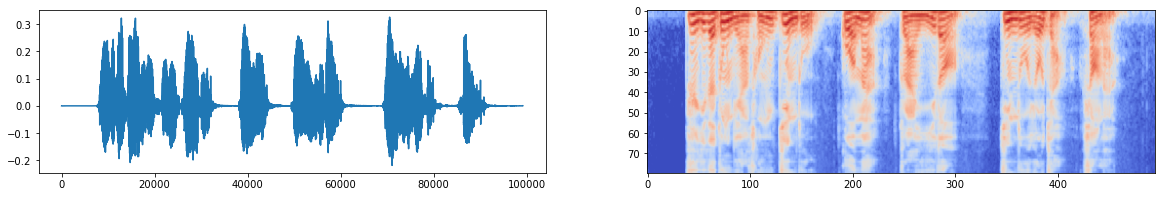

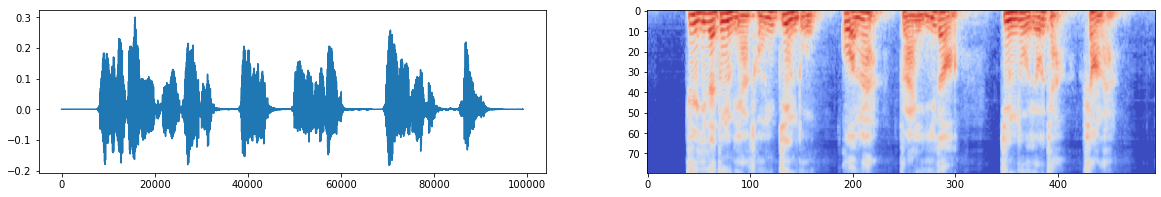

In [11]:
wav_path = '/NASdata/AudioData/AISHELL-ASR-SSB/SPEECHDATA/SSB0503/SSB05030011.wav'
wav, sr = librosa.load(wav_path, sr=16000)
display_waveform(wav)

mel = melgan(torch.from_numpy(wav)[None])[0].detach().cpu().numpy().T
recon = recon_from_mel(mel)
display_waveform(recon)

# performance test in an ideal setting

In [6]:
def gen_sample(duration, sr = 22050) : 
    return np.random.randn((int(duration * sr)))

In [12]:
times = 100
dgen = mel.size(-1) * 256 / 22050
start_time = time.perf_counter()
for i in tqdm(range(times)) : 
    recon = melgan.inverse(mel).squeeze().cpu().numpy()
end_time = time.perf_counter()

print(f'time elapsed : {end_time-start_time}, r = {times * dgen / (end_time - start_time)}')

100%|██████████| 100/100 [00:01<00:00, 74.95it/s]

time elapsed : 1.3381641460582614, r = 298.4560759089865


In [28]:
print(dgen)

3.9938321995464854


# recon from mel-files

float32
float32
mel_tensor : (torch.Size([1, 80, 212])) -> recon_wav : ((42400,))
audio sample ((42400,), (80, 212)) : 


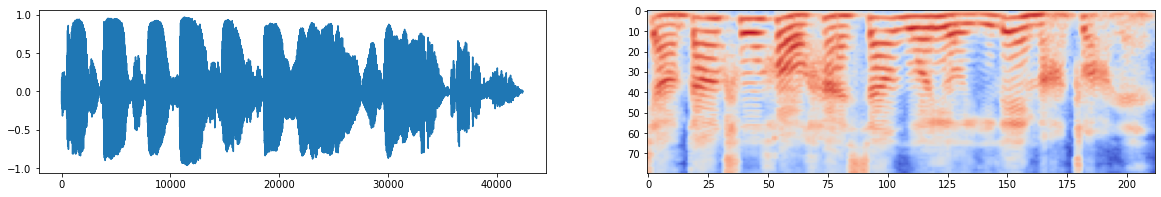

In [12]:

display_waveform(
    recon_from_mel(
        np.load(get_synth_mel(53))
    )
)



# difference between high-resolution mel and smoothed mels

audio sample ((99169,), (80, 495)) : 


float32
float32
mel_tensor : (torch.Size([1, 80, 495])) -> recon_wav : ((99000,))
audio sample ((99000,), (80, 495)) : 


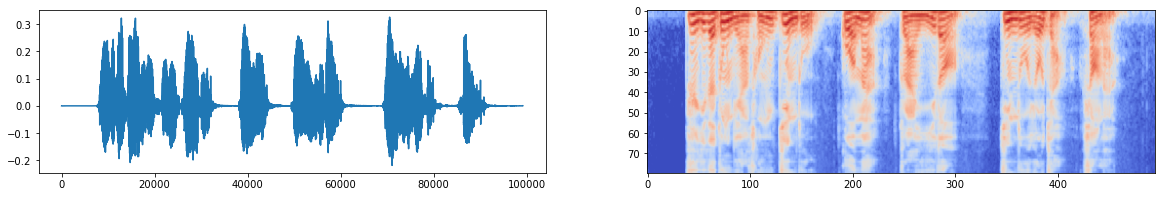

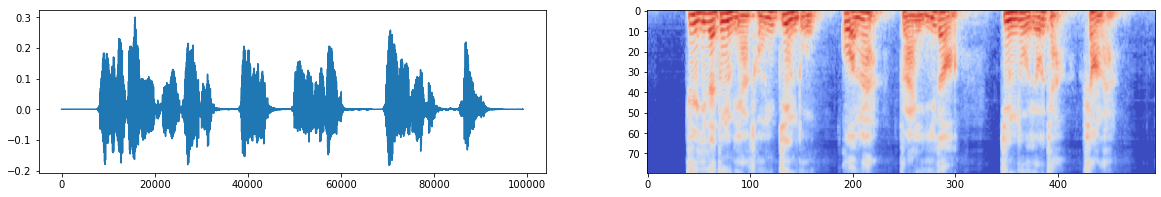

In [13]:
wav_path = '/NASdata/AudioData/AISHELL-ASR-SSB/SPEECHDATA/SSB0503/SSB05030011.wav'
wav, sr = librosa.load(wav_path, sr=16000)
display_waveform(wav)

mel = melgan(torch.from_numpy(wav)[None])[0].detach().cpu().numpy().T
recon = recon_from_mel(mel)
display_waveform(recon)

In [15]:
nps

(495, 80)

# yyg test

In [10]:
path='/Netdata/yangyg/workspace/DeepLearningExamples/PyTorch/SpeechSynthesis/Tacotron2/output-mel/'
for file in os.listdir(path):
    a = np.load(os.path.join(path,'my-english-mel.npy')).squeeze().T
    a = a.astype(np.float32)
    print(a.shape)
    display_waveform(
    recon_from_mel(a
    )
)



(365, 80)
float32
float32
mel_tensor : (torch.Size([1, 80, 365])) -> recon_wav : ((73000,))
audio sample ((73000,), (80, 365)) : 


(365, 80)
float32
float32
mel_tensor : (torch.Size([1, 80, 365])) -> recon_wav : ((73000,))
audio sample ((73000,), (80, 365)) : 


(365, 80)
float32
float32
mel_tensor : (torch.Size([1, 80, 365])) -> recon_wav : ((73000,))
audio sample ((73000,), (80, 365)) : 


(365, 80)
float32
float32
mel_tensor : (torch.Size([1, 80, 365])) -> recon_wav : ((73000,))
audio sample ((73000,), (80, 365)) : 


(365, 80)
float32
float32
mel_tensor : (torch.Size([1, 80, 365])) -> recon_wav : ((73000,))
audio sample ((73000,), (80, 365)) : 


(365, 80)
float32
float32
mel_tensor : (torch.Size([1, 80, 365])) -> recon_wav : ((73000,))
audio sample ((73000,), (80, 365)) : 


(365, 80)
float32
float32
mel_tensor : (torch.Size([1, 80, 365])) -> recon_wav : ((73000,))
audio sample ((73000,), (80, 365)) : 


(365, 80)
float32
float32
mel_tensor : (torch.Size([1, 80, 365])) -> recon_wav : ((73000,))
audio sample ((73000,), (80, 365)) : 


(365, 80)
float32
float32
mel_tensor : (torch.Size([1, 80, 365])) -> recon_wav : ((73000,))
audio sample ((73000,), (80, 365)) : 


float32
float32
mel_tensor : (torch.Size([1, 80, 287])) -> recon_wav : ((57400,))
audio sample ((57400,), (80, 287)) : 


audio sample ((57400,), (80, 287)) : 


audio sample ((75922,), (80, 379)) : 


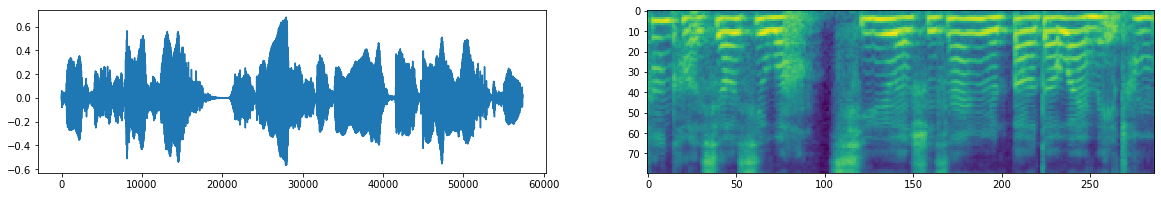

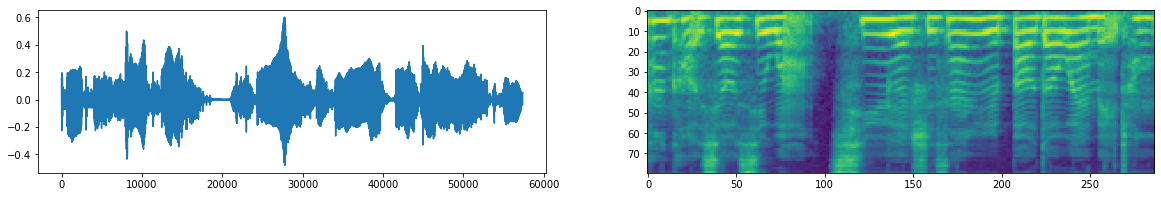

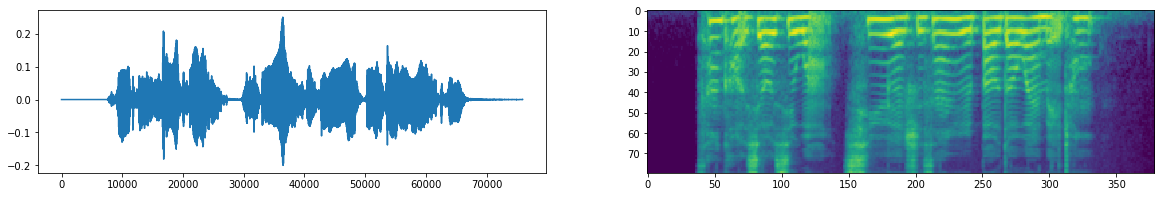

In [22]:
sid = (1635,179)
display_waveform(
    recon_from_mel(
        np.load(get_gta_mel(*sid))
    )
)

display_waveform(
    np.load(get_real_audio(*sid))
)

display_waveform(
    librosa.core.load(get_hf_audio(*sid), sr=16000)[0]
)

In [7]:
x1 = recon_from_mel(np.load(get_gta_mel(*sid)))
x2 = np.load(get_real_audio(*sid))

float32
float32
mel_tensor : (torch.Size([1, 80, 275])) -> recon_wav : ((55000,))


In [8]:
Audio(x1 - x2, rate=samplerate)

audio sample ((55000,), (80, 275)) : 


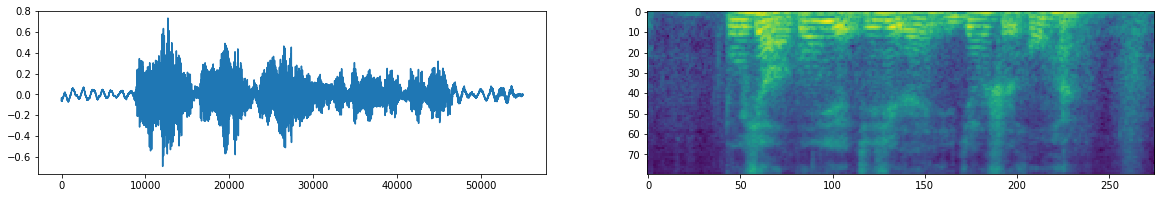

In [9]:
display_waveform(x2-x1)

float32
float32
mel_tensor : (torch.Size([1, 80, 269])) -> recon_wav : ((53800,))
audio sample ((53800,), (80, 269)) : 


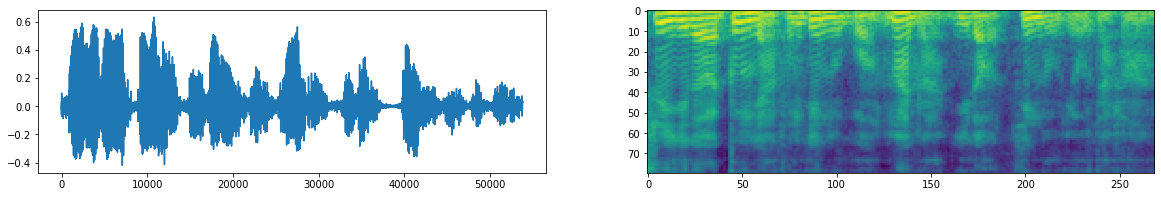

In [10]:
display_waveform(
    recon_from_mel(
        np.load(get_natural_mel(503,11))
    )
)

/home/shiyao/netdata/tacotron_base/manual_debug/natural/mel-3.npy
float32
float32
mel_tensor : (torch.Size([1, 80, 184])) -> recon_wav : ((36800,))
audio sample ((36800,), (80, 184)) : 


/home/shiyao/netdata/tacotron_base/manual_debug/natural/mel-SSB0378_6.npy
float32
float32
mel_tensor : (torch.Size([1, 80, 344])) -> recon_wav : ((68800,))
audio sample ((68800,), (80, 344)) : 


/home/shiyao/netdata/tacotron_base/manual_debug/natural/mel-SSB1635_3.npy
float32
float32
mel_tensor : (torch.Size([1, 80, 265])) -> recon_wav : ((53000,))
audio sample ((53000,), (80, 265)) : 


/home/shiyao/netdata/tacotron_base/manual_debug/natural/mel-SSB1444_2.npy
float32
float32
mel_tensor : (torch.Size([1, 80, 286])) -> recon_wav : ((57200,))
audio sample ((57200,), (80, 286)) : 


/home/shiyao/netdata/tacotron_base/manual_debug/natural/mel-SSB0642_7.npy
float32
float32
mel_tensor : (torch.Size([1, 80, 189])) -> recon_wav : ((37800,))
audio sample ((37800,), (80, 189)) : 


/home/shiyao/netdata/tacotron_base/manual_debug/natural/mel-SSB0287_8.npy
float32
float32
mel_tensor : (torch.Size([1, 80, 242])) -> recon_wav : ((48400,))
audio sample ((48400,), (80, 242)) : 


/home/shiyao/netdata/tacotron_base/manual_debug/natural/mel-SSB0287_0.npy
float32
float32
mel_tensor : (torch.Size([1, 80, 98])) -> recon_wav : ((19600,))
audio sample ((19600,), (80, 98)) : 


/home/shiyao/netdata/tacotron_base/manual_debug/natural/mel-11.npy
float32
float32
mel_tensor : (torch.Size([1, 80, 200])) -> recon_wav : ((40000,))
audio sample ((40000,), (80, 200)) : 


/home/shiyao/netdata/tacotron_base/manual_debug/natural/mel-SSB0051_3.npy
float32
float32
mel_tensor : (torch.Size([1, 80, 339])) -> recon_wav : ((67800,))
audio sample ((67800,), (80, 339)) : 


/home/shiyao/netdata/tacotron_base/manual_debug/natural/mel-SSB1971_7.npy
float32
float32
mel_tensor : (torch.Size([1, 80, 195])) -> recon_wav : ((39000,))
audio sample ((39000,), (80, 195)) : 


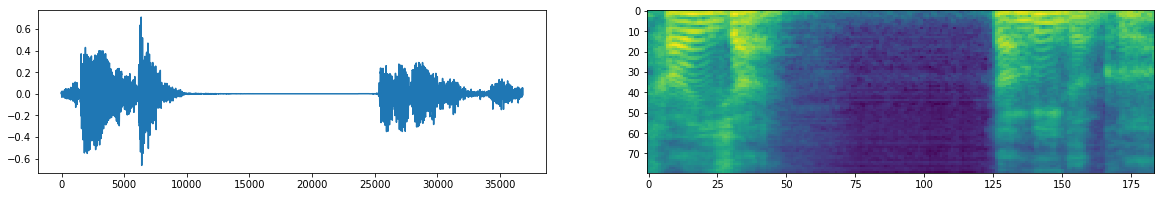

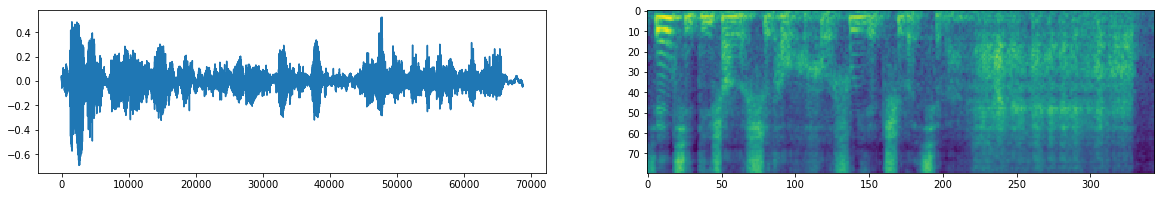

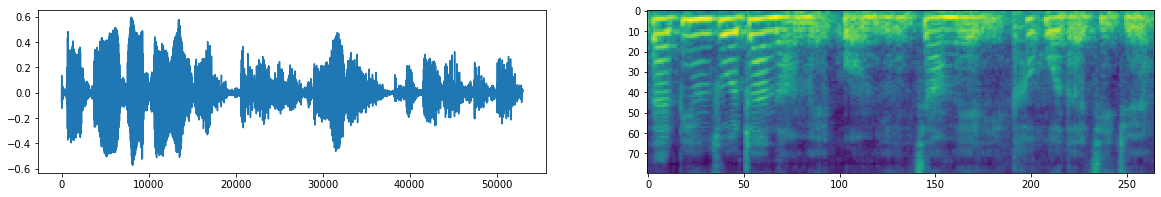

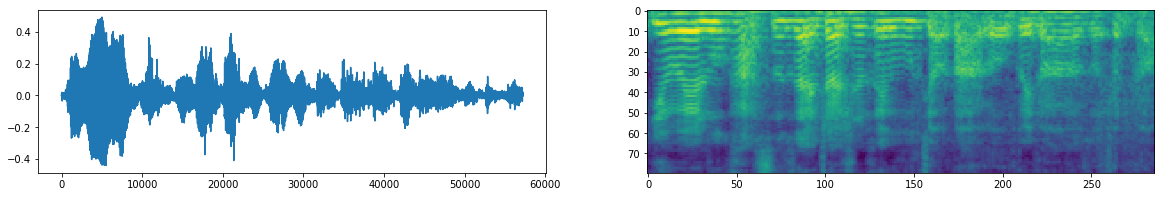

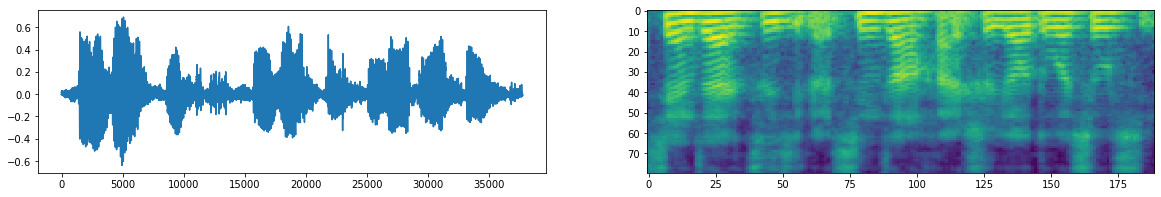

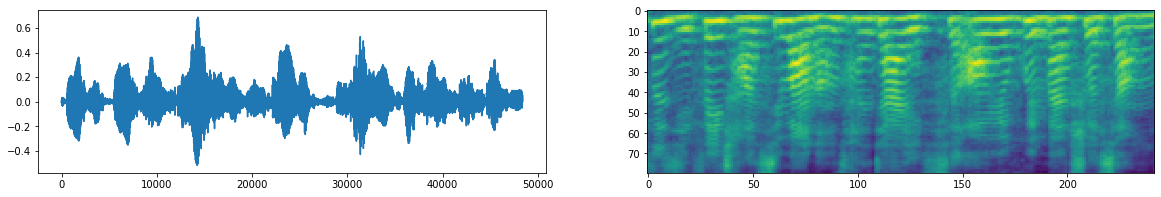

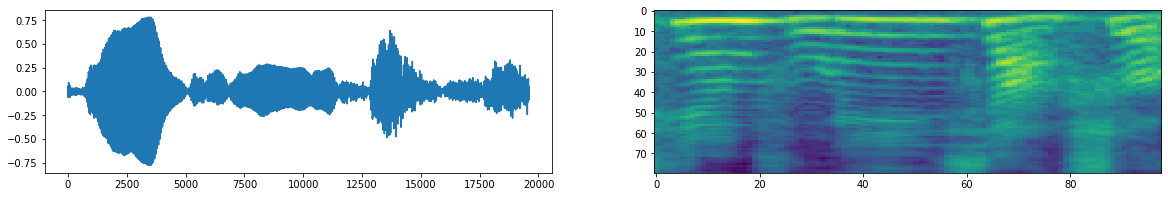

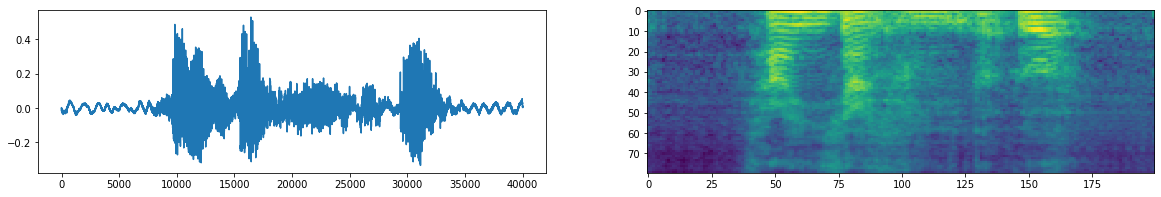

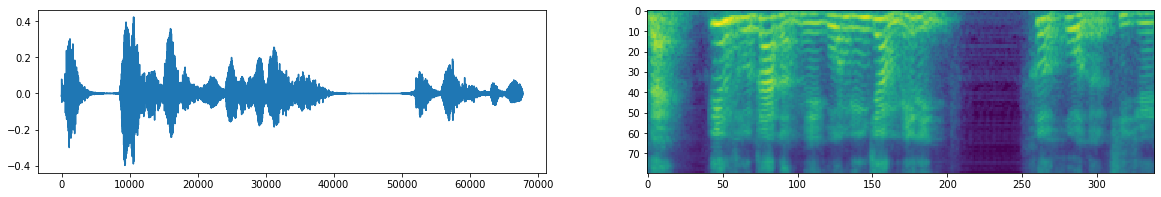

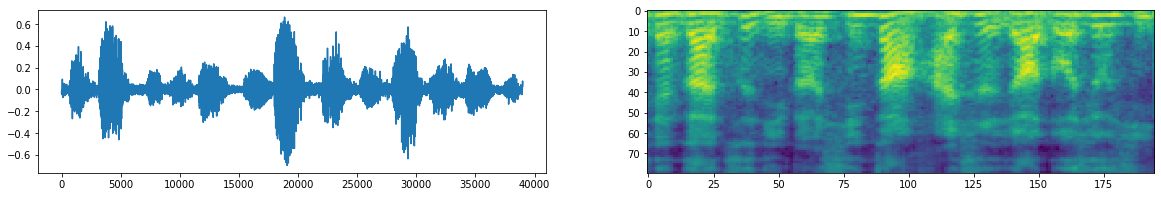

In [20]:


for p in random.sample(glob.glob('/home/shiyao/netdata/tacotron_base/manual_debug/natural/*.npy'), 10) : 
    print(p)
    display_waveform(
        recon_from_mel(
            np.load(p)
        )
    )

In [16]:
! mkdir recon_experiment/melgan_bad

In [17]:
for p in tqdm(glob.glob('/home/shiyao/netdata/tacotron_base/manual_debug/natural/*.npy')) : 
    write_waveform(
        recon_from_mel(
            np.load(p)
        ),
        f'recon_experiment/melgan_bad/r_{os.path.basename(p)}.wav'
    )

  3%|▎         | 7/216 [00:00<00:03, 61.42it/s]

float32
float32
mel_tensor : (torch.Size([1, 80, 159])) -> recon_wav : ((31800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 104])) -> recon_wav : ((20800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 106])) -> recon_wav : ((21200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 184])) -> recon_wav : ((36800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 122])) -> recon_wav : ((24400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 195])) -> recon_wav : ((39000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 117])) -> recon_wav : ((23400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 109])) -> recon_wav : ((21800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 149])) -> recon_wav : ((29800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 118])) -> recon_wav : ((23600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 174])) -> recon_wav : ((34800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 200])) -> recon_wav : ((40000,))
float32
float32


  9%|▉         | 19/216 [00:00<00:03, 55.41it/s]

mel_tensor : (torch.Size([1, 80, 110])) -> recon_wav : ((22000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 113])) -> recon_wav : ((22600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 115])) -> recon_wav : ((23000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 153])) -> recon_wav : ((30600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 187])) -> recon_wav : ((37400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 390])) -> recon_wav : ((78000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 308])) -> recon_wav : ((61600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 293])) -> recon_wav : ((58600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 215])) -> recon_wav : ((43000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 280])) -> recon_wav : ((56000,))
float32
float32


 14%|█▍        | 31/216 [00:00<00:03, 53.46it/s]

mel_tensor : (torch.Size([1, 80, 261])) -> recon_wav : ((52200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 269])) -> recon_wav : ((53800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 320])) -> recon_wav : ((64000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 218])) -> recon_wav : ((43600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 103])) -> recon_wav : ((20600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 352])) -> recon_wav : ((70400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 274])) -> recon_wav : ((54800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 236])) -> recon_wav : ((47200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 124])) -> recon_wav : ((24800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 202])) -> recon_wav : ((40400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 194])) -> recon_wav : ((38800,))
float32
float32


 19%|█▉        | 42/216 [00:00<00:03, 52.24it/s]

mel_tensor : (torch.Size([1, 80, 189])) -> recon_wav : ((37800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 268])) -> recon_wav : ((53600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 125])) -> recon_wav : ((25000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 175])) -> recon_wav : ((35000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 322])) -> recon_wav : ((64400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 286])) -> recon_wav : ((57200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 263])) -> recon_wav : ((52600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 176])) -> recon_wav : ((35200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 159])) -> recon_wav : ((31800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 216])) -> recon_wav : ((43200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 204])) -> recon_wav : ((40800,))


 25%|██▌       | 54/216 [00:01<00:03, 52.25it/s]

float32
float32
mel_tensor : (torch.Size([1, 80, 273])) -> recon_wav : ((54600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 199])) -> recon_wav : ((39800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 99])) -> recon_wav : ((19800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 344])) -> recon_wav : ((68800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 348])) -> recon_wav : ((69600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 277])) -> recon_wav : ((55400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 106])) -> recon_wav : ((21200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 166])) -> recon_wav : ((33200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 210])) -> recon_wav : ((42000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 200])) -> recon_wav : ((40000,))
float32
float32


 31%|███       | 67/216 [00:01<00:02, 56.38it/s]

mel_tensor : (torch.Size([1, 80, 287])) -> recon_wav : ((57400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 130])) -> recon_wav : ((26000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 97])) -> recon_wav : ((19400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 318])) -> recon_wav : ((63600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 309])) -> recon_wav : ((61800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 252])) -> recon_wav : ((50400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 114])) -> recon_wav : ((22800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 164])) -> recon_wav : ((32800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 191])) -> recon_wav : ((38200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 174])) -> recon_wav : ((34800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 259])) -> recon_wav : ((51800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 134])) -> recon_wav : ((26800,))
float32
float32
mel_tensor : (tor

 34%|███▍      | 73/216 [00:01<00:03, 46.36it/s]

float32
float32
mel_tensor : (torch.Size([1, 80, 413])) -> recon_wav : ((82600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 293])) -> recon_wav : ((58600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 281])) -> recon_wav : ((56200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 104])) -> recon_wav : ((20800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 161])) -> recon_wav : ((32200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 199])) -> recon_wav : ((39800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 195])) -> recon_wav : ((39000,))


 39%|███▉      | 85/216 [00:01<00:02, 50.00it/s]

float32
float32
mel_tensor : (torch.Size([1, 80, 283])) -> recon_wav : ((56600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 123])) -> recon_wav : ((24600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 85])) -> recon_wav : ((17000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 279])) -> recon_wav : ((55800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 309])) -> recon_wav : ((61800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 217])) -> recon_wav : ((43400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 89])) -> recon_wav : ((17800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 161])) -> recon_wav : ((32200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 187])) -> recon_wav : ((37400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 177])) -> recon_wav : ((35400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 233])) -> recon_wav : ((46600,))
float32
float32


 42%|████▏     | 91/216 [00:01<00:02, 49.63it/s]

mel_tensor : (torch.Size([1, 80, 99])) -> recon_wav : ((19800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 171])) -> recon_wav : ((34200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 343])) -> recon_wav : ((68600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 395])) -> recon_wav : ((79000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 302])) -> recon_wav : ((60400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 190])) -> recon_wav : ((38000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 229])) -> recon_wav : ((45800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 203])) -> recon_wav : ((40600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 245])) -> recon_wav : ((49000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 275])) -> recon_wav : ((55000,))
float32
float32


 48%|████▊     | 103/216 [00:02<00:02, 49.94it/s]

mel_tensor : (torch.Size([1, 80, 254])) -> recon_wav : ((50800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 223])) -> recon_wav : ((44600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 330])) -> recon_wav : ((66000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 313])) -> recon_wav : ((62600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 256])) -> recon_wav : ((51200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 190])) -> recon_wav : ((38000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 193])) -> recon_wav : ((38600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 204])) -> recon_wav : ((40800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 200])) -> recon_wav : ((40000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 276])) -> recon_wav : ((55200,))
float32
float32


 53%|█████▎    | 115/216 [00:02<00:02, 49.30it/s]

mel_tensor : (torch.Size([1, 80, 228])) -> recon_wav : ((45600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 277])) -> recon_wav : ((55400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 329])) -> recon_wav : ((65800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 299])) -> recon_wav : ((59800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 360])) -> recon_wav : ((72000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 198])) -> recon_wav : ((39600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 235])) -> recon_wav : ((47000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 221])) -> recon_wav : ((44200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 253])) -> recon_wav : ((50600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 340])) -> recon_wav : ((68000,))
float32
float32


 56%|█████▌    | 120/216 [00:02<00:02, 43.19it/s]

mel_tensor : (torch.Size([1, 80, 181])) -> recon_wav : ((36200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 251])) -> recon_wav : ((50200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 425])) -> recon_wav : ((85000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 366])) -> recon_wav : ((73200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 373])) -> recon_wav : ((74600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 201])) -> recon_wav : ((40200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 228])) -> recon_wav : ((45600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 264])) -> recon_wav : ((52800,))
float32
float32


 61%|██████    | 131/216 [00:02<00:01, 46.88it/s]

mel_tensor : (torch.Size([1, 80, 278])) -> recon_wav : ((55600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 324])) -> recon_wav : ((64800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 224])) -> recon_wav : ((44800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 91])) -> recon_wav : ((18200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 340])) -> recon_wav : ((68000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 281])) -> recon_wav : ((56200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 262])) -> recon_wav : ((52400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 112])) -> recon_wav : ((22400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 176])) -> recon_wav : ((35200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 215])) -> recon_wav : ((43000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 184])) -> recon_wav : ((36800,))
float32
float32


 66%|██████▌   | 143/216 [00:02<00:01, 50.35it/s]

mel_tensor : (torch.Size([1, 80, 270])) -> recon_wav : ((54000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 126])) -> recon_wav : ((25200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 85])) -> recon_wav : ((17000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 311])) -> recon_wav : ((62200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 259])) -> recon_wav : ((51800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 282])) -> recon_wav : ((56400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 113])) -> recon_wav : ((22600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 151])) -> recon_wav : ((30200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 200])) -> recon_wav : ((40000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 181])) -> recon_wav : ((36200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 269])) -> recon_wav : ((53800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 114])) -> recon_wav : ((22800,))


 72%|███████▏  | 155/216 [00:03<00:01, 51.33it/s]

float32
float32
mel_tensor : (torch.Size([1, 80, 89])) -> recon_wav : ((17800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 314])) -> recon_wav : ((62800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 285])) -> recon_wav : ((57000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 265])) -> recon_wav : ((53000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 102])) -> recon_wav : ((20400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 168])) -> recon_wav : ((33600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 204])) -> recon_wav : ((40800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 233])) -> recon_wav : ((46600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 256])) -> recon_wav : ((51200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 130])) -> recon_wav : ((26000,))
float32
float32


 75%|███████▌  | 162/216 [00:03<00:01, 53.57it/s]

mel_tensor : (torch.Size([1, 80, 98])) -> recon_wav : ((19600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 292])) -> recon_wav : ((58400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 258])) -> recon_wav : ((51600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 222])) -> recon_wav : ((44400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 114])) -> recon_wav : ((22800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 157])) -> recon_wav : ((31400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 186])) -> recon_wav : ((37200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 160])) -> recon_wav : ((32000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 242])) -> recon_wav : ((48400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 129])) -> recon_wav : ((25800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 186])) -> recon_wav : ((37200,))
float32
float32


 81%|████████  | 174/216 [00:03<00:00, 51.42it/s]

mel_tensor : (torch.Size([1, 80, 351])) -> recon_wav : ((70200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 329])) -> recon_wav : ((65800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 268])) -> recon_wav : ((53600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 199])) -> recon_wav : ((39800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 208])) -> recon_wav : ((41600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 344])) -> recon_wav : ((68800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 208])) -> recon_wav : ((41600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 296])) -> recon_wav : ((59200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 154])) -> recon_wav : ((30800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 123])) -> recon_wav : ((24600,))
float32
float32


 86%|████████▌ | 185/216 [00:03<00:00, 48.21it/s]

mel_tensor : (torch.Size([1, 80, 390])) -> recon_wav : ((78000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 400])) -> recon_wav : ((80000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 296])) -> recon_wav : ((59200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 134])) -> recon_wav : ((26800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 208])) -> recon_wav : ((41600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 250])) -> recon_wav : ((50000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 241])) -> recon_wav : ((48200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 312])) -> recon_wav : ((62400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 148])) -> recon_wav : ((29600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 86])) -> recon_wav : ((17200,))
float32
float32


 92%|█████████▏| 198/216 [00:03<00:00, 52.46it/s]

mel_tensor : (torch.Size([1, 80, 248])) -> recon_wav : ((49600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 221])) -> recon_wav : ((44200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 192])) -> recon_wav : ((38400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 92])) -> recon_wav : ((18400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 143])) -> recon_wav : ((28600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 165])) -> recon_wav : ((33000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 150])) -> recon_wav : ((30000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 218])) -> recon_wav : ((43600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 114])) -> recon_wav : ((22800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 100])) -> recon_wav : ((20000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 379])) -> recon_wav : ((75800,))
float32
float32


 94%|█████████▍| 204/216 [00:04<00:00, 50.75it/s]

mel_tensor : (torch.Size([1, 80, 388])) -> recon_wav : ((77600,))
float32
float32
mel_tensor : (torch.Size([1, 80, 339])) -> recon_wav : ((67800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 110])) -> recon_wav : ((22000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 169])) -> recon_wav : ((33800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 260])) -> recon_wav : ((52000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 180])) -> recon_wav : ((36000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 342])) -> recon_wav : ((68400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 159])) -> recon_wav : ((31800,))
float32
float32
mel_tensor : (torch.Size([1, 80, 110])) -> recon_wav : ((22000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 505])) -> recon_wav : ((101000,))


100%|██████████| 216/216 [00:04<00:00, 49.93it/s]

float32
float32
mel_tensor : (torch.Size([1, 80, 382])) -> recon_wav : ((76400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 530])) -> recon_wav : ((106000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 116])) -> recon_wav : ((23200,))
float32
float32
mel_tensor : (torch.Size([1, 80, 177])) -> recon_wav : ((35400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 265])) -> recon_wav : ((53000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 322])) -> recon_wav : ((64400,))
float32
float32
mel_tensor : (torch.Size([1, 80, 245])) -> recon_wav : ((49000,))
float32
float32
mel_tensor : (torch.Size([1, 80, 129])) -> recon_wav : ((25800,))


In [14]:
! pwd

/home/shiyao/netdata/melgan/melgan-archodd


In [22]:
1 + 1

2

In [23]:
1 + 1

2

In [26]:
__file__

NameError: name '__file__' is not defined

In [85]:
import time
from tqdm.notebook import tqdm

In [86]:
for i in tqdm(range(100)) : 
    x = 1
    time.sleep(0.1)

In [4]:
import tensorflow as tf
from glob import glob

def get_loss_from_tfevent_file(tfevent_filename):
    """

    :param tfevent_filename: the name of one tfevent file
    :return: loss (list)
    """
    res = {}
    for event in tf.train.summary_iterator(tfevent_filename):
        for value in event.summary.value:
#             print(value.tag)
            if value.HasField('simple_value'):
                if value.tag not in res : 
                    res[value.tag] = []
                res[value.tag].append(value.simple_value)
    return res

def from_tfevent(run_name) : 
    res = {}
    filename = glob(os.path.join(run_name,'events.*'))
    for f in filename : 
        t = get_loss_from_tfevent_file(f)
        for k,v in t.items() :
            if k not in res : 
                res[k] = []
            res[k] += [v]
    return res

In [9]:
res = from_tfevent('logs/handpicked_ssb_odd')

In [10]:
res.keys()

dict_keys(['loss/discriminator', 'loss/generator', 'loss/feature_matching', 'loss/mel_reconstruction'])

In [14]:
len(res['loss/feature_matching'][0])

3170028

In [ ]:
def purify_sent(sent : str) -> Tuple[str, List[Tuple[int, str]]]:
    bagage = []
    pured = []
    last_start = 0

    while True :
    m = unpure_pattern.search(sent)
    if m is not None :
    start,end = m.span()
    content = m.group()
    bagage.append((start + last_start, content))
    pured.append(sent[:start])

    sent = sent[end:]
    last_start += start

    else :
    pured.append(sent)
    return ''.join(pured),bagage
